# Embedding and Filtering Inference 

Set default input and output directories according to local paths for data

In [ ]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest" 

Import necessary libraries and functions

In [2]:
import pkg_resources
import yaml
import pprint
import random
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.cm as cm
import sys
# %matplotlib widget

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial



In [3]:
noise_keep = ['0','0.2','0.4','0.6','0.8','1']
plt.rcParams.update({'font.size': 14, 'axes.labelsize' : 14})
noise_labels = [f'{float(n)*0.2*100:.0f}' for n in noise_keep]

## Adding Noise

In [4]:
def plot_noise_dist(noise_keeps):
    noise = []
    not_noise = []
    for i in noise_keeps:
        data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n{i}/feature_store/1000"
        #data = torch.load(f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/feature_store_endcaps/n{i}/1000")
        data = torch.load(data_path)
        arr = data['pid']
        n_count = np.count_nonzero(arr==0)
        not_n = np.count_nonzero(arr)
        noise.append(n_count)
        not_noise.append(not_n)
        print("-----")
        print(data)

    x = np.arange(len(noise_keeps))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,5))
    rects1 = ax.bar(x - width/2, noise, width, label='noise')
    rects2 = ax.bar(x + width/2, not_noise, width, label='not noise')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('# of hits')
    ax.set_xlabel('Percentage Noise')
    ax.set_xticks(x)
    ax.set_xticklabels(noise_labels)
    ax.legend()
    
    fig2, ax2 = plt.subplots(figsize=(10,5))
    ax2.plot(x,noise, label='noise')
    ax2.set_ylabel('# of hits')
    ax2.set_xlabel('Percentage Noise')
    ax2.set_xticks(x)
    ax2.set_xticklabels(noise_labels)
    ax2.legend()
    
    fig3, ax3 = plt.subplots(figsize=(10,5))
    ax3.plot(x,not_noise, label='not noise')
    ax3.set_ylabel('# of hits')
    ax3.set_xlabel('Percentage Noise')
    ax3.set_xticks(x)
    ax3.set_xticklabels(noise_labels)
    ax3.legend()

-----
Data(cell_data=[103305, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all/event000001000", hid=[103305], layerless_true_edges=[2, 123429], layers=[103305], pid=[103305], x=[103305, 3])
-----
Data(cell_data=[106831, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all/event000001000", hid=[106831], layerless_true_edges=[2, 123429], layers=[103305], pid=[106831], x=[106831, 3])
-----
Data(cell_data=[110358, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_100_events/event000001000", hid=[110358], layerless_true_edges=[2, 123429], layers=[103305], pid=[110358], x=[110358, 3])
-----
Data(cell_data=[113885, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_100_events/event000001000", hid=[113885], layerless_true_edges=[2, 123429], layers=[103305], pid=[113885], x=[113885, 3])
-----
Data(cell_data=[117412, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/tr

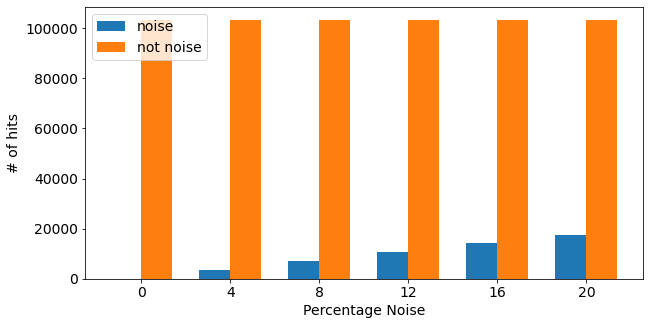

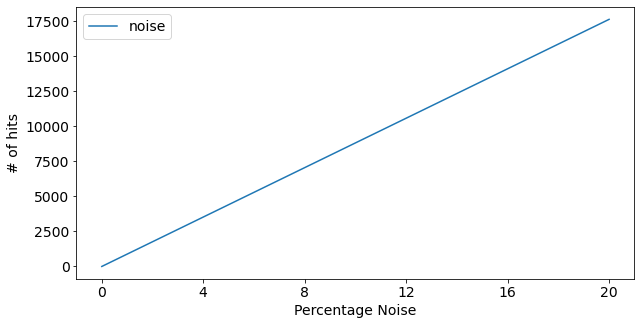

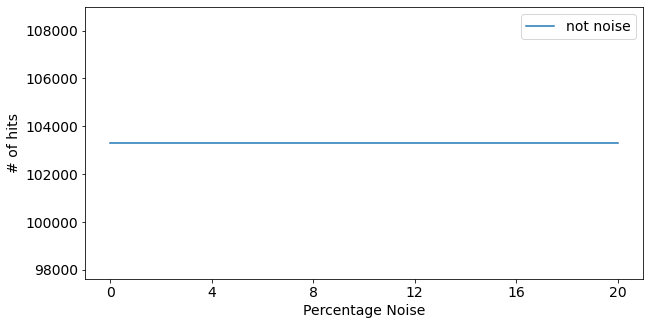

In [5]:
noise_keep = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
plot_noise_dist(noise_keep)

## Embedding

Set checkpoint and other directory paths

In [6]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/run1' # needs to change...

Fixing some parameters

In [7]:
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

Load embedding model from checkpoint

In [8]:
emb_ckpt = torch.load(embed_ckpt_dir, map_location='cpu')
emb_ckpt['hyper_parameters']['train_split'] = [8,1,1]
emb_ckpt['hyper_parameters']['clustering'] = 'build_edges'
emb_ckpt['hyper_parameters']['knn_val'] = 500
emb_ckpt['hyper_parameters']['r_val'] = 1.7
emb_ckpt['hyper_parameters']

"adjacent":       False
"clustering":     build_edges
"emb_dim":        8
"emb_hidden":     512
"endcaps":        True
"factor":         0.3
"in_channels":    12
"input_dir":      /global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps
"knn":            20
"knn_val":        500
"layerless":      True
"layerwise":      False
"lr":             0.002
"margin":         1
"max_epochs":     100
"nb_layer":       6
"noise":          False
"output_dir":     global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps
"overwrite":      True
"patience":       5
"project":        EmbeddingStudy
"pt_min":         0
"r_train":        1
"r_val":          1.7
"randomisation":  2
"regime":         ['rp', 'hnm', 'ci']
"train_split":    [8, 1, 1]
"wandb_save_dir": /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data
"warmup":         500
"weight":         4

In [9]:
emb_model = LayerlessEmbedding(emb_ckpt['hyper_parameters'])
emb_model.load_state_dict(emb_ckpt["state_dict"])

<All keys matched successfully>

Put model in evaluation state

In [10]:
emb_model.eval()

LayerlessEmbedding(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_layer): Linear(in_features=512, out_features=8, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (act): Tanh()
)

Define embedding metrics (function gets metrics for one event)

In [11]:
def get_emb_metrics(data_path, emb_model,r_val=1.7,knn_val=500):
    data = torch.load(data_path)
    spatial = emb_model(torch.cat([data.cell_data, data.x], axis=-1))
    
    if(torch.cuda.is_available()):
        spatial = spatial.cuda()
        
    e_spatial = utils_torch.build_edges(spatial, r_val, knn_val)
    e_spatial_np = e_spatial.cpu().numpy()
    
    # remove R dist from out to in
    R_dist = torch.sqrt(data.x[:,0]**2 + data.x[:,2]**2)
    
    e_spatial_np = e_spatial_np[:, (R_dist[e_spatial_np[0]] <= R_dist[e_spatial_np[1]])]
    e_bidir = torch.cat([data.layerless_true_edges,torch.stack([data.layerless_true_edges[1],
                        data.layerless_true_edges[0]], axis=1).T], axis=-1)
    e_spatial_n, y_cluster = graph_intersection(torch.from_numpy(e_spatial_np), e_bidir)
    
    cluster_true = len(data.layerless_true_edges[0])
    cluster_true_positive = y_cluster.sum()
    cluster_positive = len(e_spatial_n[0])
    purity = cluster_true_positive/cluster_positive
    eff = cluster_true_positive/cluster_true
    
    print("-----------")
    print(f"cluster true = {cluster_true}")
    print(f"cluste true positive = {cluster_true_positive}")
    print(f"cluster positive = {cluster_positive}")
    print(f"purity = {purity}")
    print(f"efficiency = {eff}")
    
    return purity, eff

Metrics for one event and all noise configurations

In [12]:
%%time
p_all = []
e_all = []
for i in noise_keep:
    data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n{i}/feature_store/1000"
    p, e = get_emb_metrics(data_path, emb_model)
    p_all.append(p)
    e_all.append(e)

-----------
cluster true = 123429
cluste true positive = 120268
cluster positive = 10048694
purity = 0.011968520486343797
efficiency = 0.9743901352194378
-----------
cluster true = 123429
cluste true positive = 120224
cluster positive = 10905936
purity = 0.011023721393560351
efficiency = 0.974033654975735
-----------
cluster true = 123429
cluste true positive = 120177
cluster positive = 11801009
purity = 0.010183620739548626
efficiency = 0.9736528692608706
-----------
cluster true = 123429
cluste true positive = 120112
cluster positive = 12708668
purity = 0.009451187173982356
efficiency = 0.9731262507190368
-----------
cluster true = 123429
cluste true positive = 120049
cluster positive = 13655061
purity = 0.008791538902682309
efficiency = 0.9726158358246442
-----------
cluster true = 123429
cluste true positive = 119986
cluster positive = 14602260
purity = 0.00821694723967386
efficiency = 0.9721054209302514
CPU times: user 2h 9min 27s, sys: 41.9 s, total: 2h 10min 9s
Wall time: 8min 2

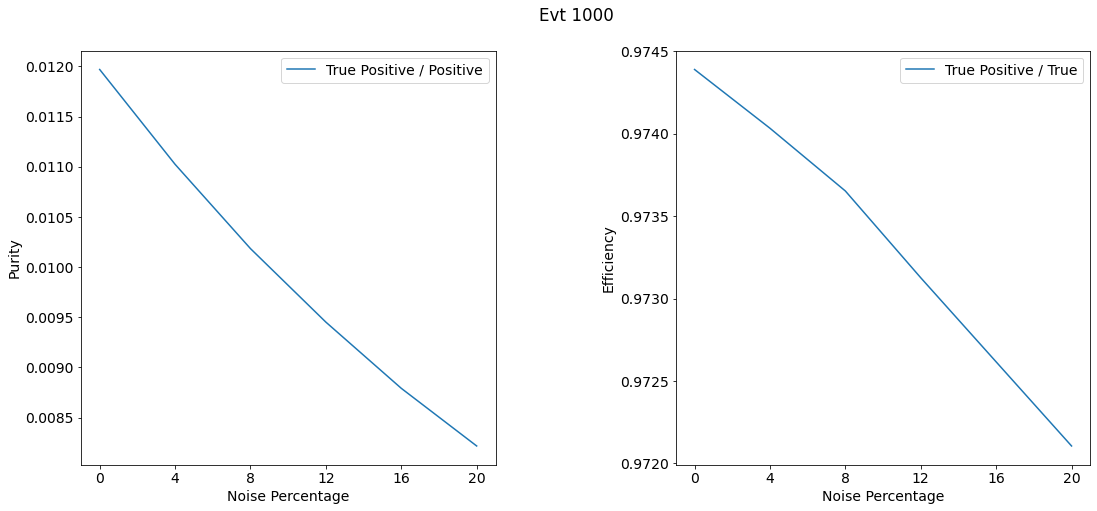

In [13]:
x = np.arange(len(noise_keep))
fig1, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
fig1.suptitle('Evt 1000')
fig1.tight_layout(w_pad = 10)
ax1.plot(x, p_all, label = 'True Positive / Positive')
ax1.set_xlabel('Noise Percentage')
ax1.set_ylabel('Purity')
ax1.set_xticks(x)
ax1.set_xticklabels(noise_labels)
ax1.legend()

ax2.plot(x, e_all, label = 'True Positive / True')
ax2.set_xlabel('Noise Percentage')
ax2.set_ylabel('Efficiency')
ax2.set_xticks(x)
ax2.set_xticklabels(noise_labels)
ax2.legend()

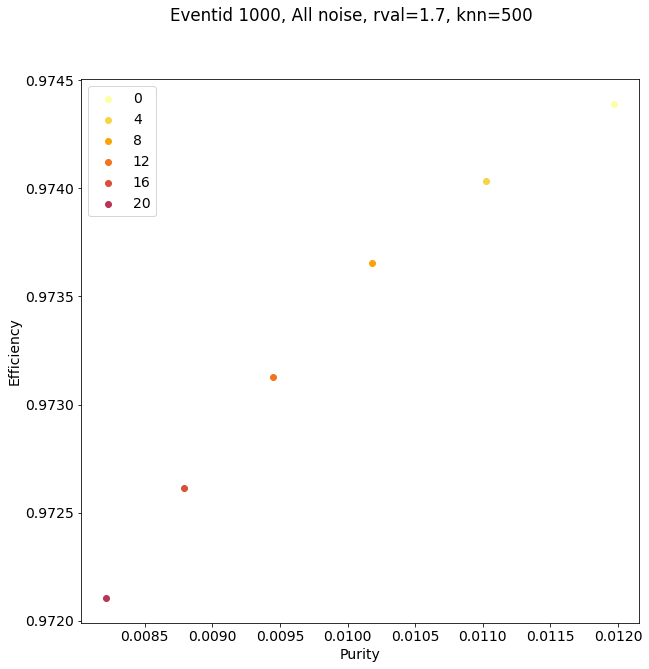

In [25]:
fig2, ax = plt.subplots(figsize=(10,10))
fig2.suptitle(f'Eventid 1000, All noise, rval=1.7, knn=500')
colors = cm.inferno_r(np.linspace(0,5))
for i,noise in enumerate(noise_keep):
    ax.scatter(p_all[i],e_all[i], color = colors[i], label = f'{float(noise)*0.2*100:.0f}')
ax.set_xlabel('Purity')
ax.set_ylabel('Efficiency')
ax.legend()

Average metrics for all events and all noise configurations

In [15]:
def get_lvl_emb(mypath,emb_model,r_val=1.7,knn_val=500):
    events = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    p_lvl = []
    e_lvl = []
    for evt in events:
        data_path = join(mypath,evt)
        p, e = get_emb_metrics(data_path, emb_model,r_val,knn_val) 
        p_lvl.append(p)
        e_lvl.append(e)
    
    return np.mean(p_lvl), np.mean(e_lvl)

In [16]:
# p_avg = []
# e_avg = []
# for i in noise_keep:
#     data_path = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{i}/feature_store/'
#     p, e = get_lvl_emb(data_path,emb_model)
#     p_avg.append(p)
#     e_avg.append(e)

In [17]:
# x = np.arange(len(noise_keep))
# fig2, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
# fig2.tight_layout(w_pad = 10)
# fig2.suptitle('10 Events')
# ax1.plot(x, p_avg, label = 'True Positive / Positive')
# ax1.set_xlabel('noise_level')
# ax1.set_ylabel('Purity')
# ax1.set_xticks(x)
# ax1.set_xticklabels(noise_keep)
# ax1.legend()

# ax2.plot(x, e_avg, label = 'True Positive / True')
# ax2.set_xlabel('noise_level')
# ax2.set_ylabel('Efficiency')
# ax2.set_xticks(x)
# ax2.set_xticklabels(noise_keep)
# ax2.legend()

Tuning Hyperparameters `r_val = 1.7` and `knn_val = 500` with a set level of noise for a specific event.

* `r_val` defines the radius of the clustering method
* `knn_val` defines the number of maximum neighbors in the embedding space

In [18]:
noise_lvl = 1
evtid = 1000
# set_event = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest/out{noise_lvl}/feature_store/{evtid}'

In [19]:
%%time
rvals = np.arange(1,2,0.1)
p_val = []
e_val = []
for n in rvals:
    data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store/1000"
    pv, ev = get_emb_metrics(data_path, emb_model,n,500)
    p_val.append(pv)
    e_val.append(ev)

-----------
cluster true = 123429
cluste true positive = 107702
cluster positive = 1007252
purity = 0.10692656852505629
efficiency = 0.87258261834739
-----------
cluster true = 123429
cluste true positive = 111661
cluster positive = 1570536
purity = 0.0710973833137222
efficiency = 0.9046577384569267
-----------
cluster true = 123429
cluste true positive = 114366
cluster positive = 2466365
purity = 0.046370265552746655
efficiency = 0.9265731716209319
-----------
cluster true = 123429
cluste true positive = 116409
cluster positive = 3854267
purity = 0.030202629968292285
efficiency = 0.9431251974819532
-----------
cluster true = 123429
cluste true positive = 117853
cluster positive = 5884963
purity = 0.02002612420842748
efficiency = 0.9548242309343833
-----------
cluster true = 123429
cluste true positive = 118865
cluster positive = 8503277
purity = 0.013978728436107632
efficiency = 0.963023276539549
-----------
cluster true = 123429
cluste true positive = 119521
cluster positive = 114771

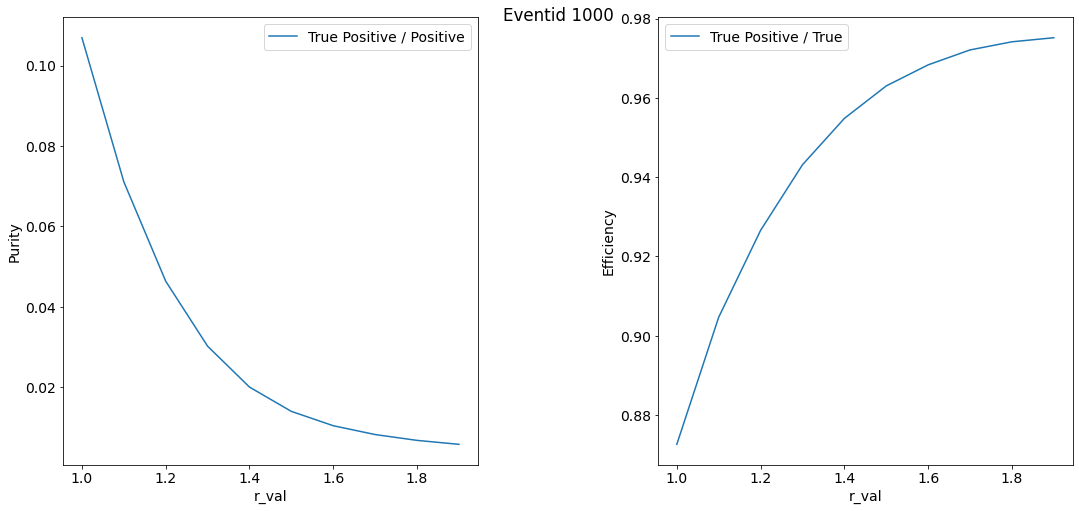

In [20]:
fig3, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
fig3.tight_layout(w_pad = 10)
fig3.suptitle(f'Eventid {evtid}')
ax1.plot(rvals, p_val, label = 'True Positive / Positive')
ax1.set_xlabel('r_val')
ax1.set_ylabel('Purity')
# ax1.set_xticks(rvals)
ax1.legend()

ax2.plot(rvals, e_val, label = 'True Positive / True')
ax2.set_xlabel('r_val')
ax2.set_ylabel('Efficiency')
# ax2.set_xticks(x)
ax2.legend()

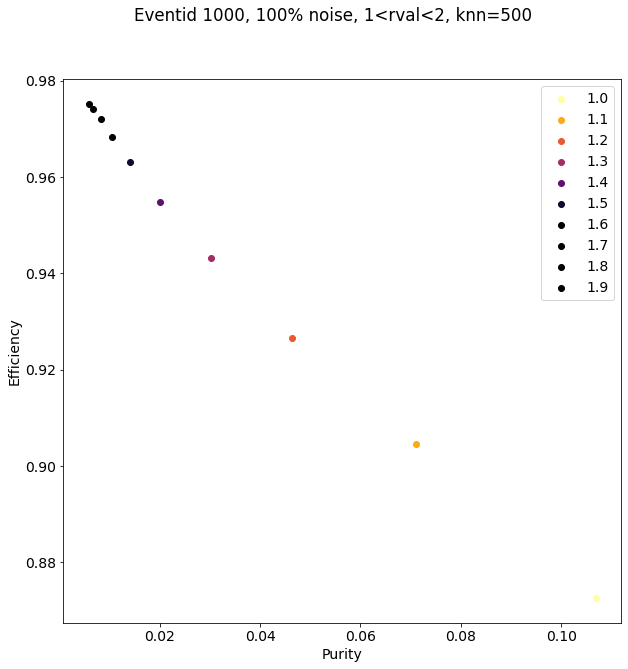

In [21]:
fig4, ax = plt.subplots(figsize=(10,10))
fig4.suptitle(f'Eventid {evtid}, 100% noise, 1<rval<2, knn=500')
n = len(p_val)-1
colors = cm.inferno_r(np.linspace(0,n))
for i,val in enumerate(rvals):
    ax.scatter(p_val[i],e_val[i], color = colors[i], label = f'{val:.1f}')
ax.set_xlabel('Purity')
ax.set_ylabel('Efficiency')
ax.legend()

In [22]:
%%time
step = np.arange(400,500,10)
p_kval = []
e_kval = []
data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store/1000"
for n in step:
    pv, ev = get_emb_metrics(data_path, emb_model,1.7,n.item())
    p_kval.append(pv)
    e_kval.append(ev)

-----------
cluster true = 123429
cluste true positive = 119713
cluster positive = 13298169
purity = 0.00900221677134649
efficiency = 0.9698936230545496
-----------
cluster true = 123429
cluste true positive = 119745
cluster positive = 13443931
purity = 0.00890699305136273
efficiency = 0.9701528814136062
-----------
cluster true = 123429
cluste true positive = 119790
cluster positive = 13586135
purity = 0.008817077115750726
efficiency = 0.9705174634810296
-----------
cluster true = 123429
cluste true positive = 119817
cluster positive = 13724662
purity = 0.008730051056995064
efficiency = 0.9707362127214836
-----------
cluster true = 123429
cluste true positive = 119841
cluster positive = 13859559
purity = 0.008646811922370691
efficiency = 0.970930656490776
-----------
cluster true = 123429
cluste true positive = 119863
cluster positive = 13991572
purity = 0.00856680007078547
efficiency = 0.9711088966126274
-----------
cluster true = 123429
cluste true positive = 119891
cluster positive

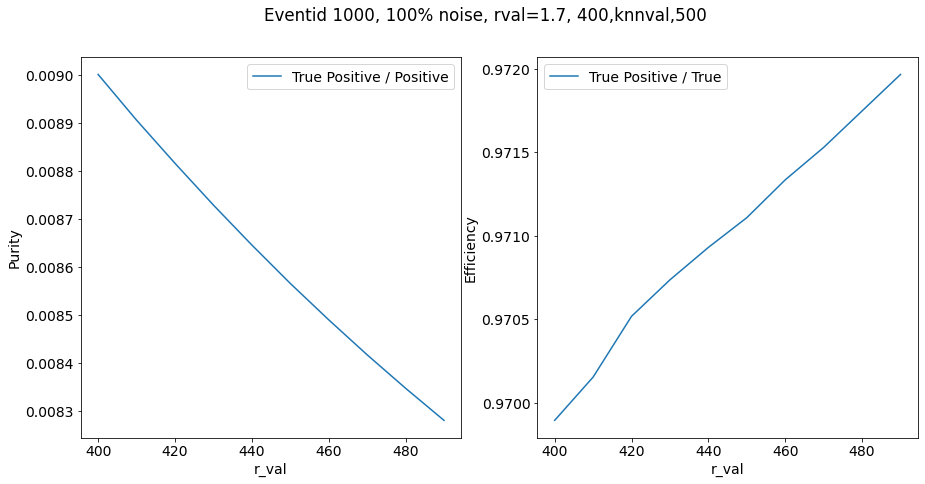

In [23]:
fig5, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
fig5.suptitle(f'Eventid {evtid}, 100% noise, rval=1.7, 400,knnval,500')
ax1.plot(step, p_kval, label = 'True Positive / Positive')
ax1.set_xlabel('r_val')
ax1.set_ylabel('Purity')
ax1.legend()

ax2.plot(step, e_kval, label = 'True Positive / True')
ax2.set_xlabel('r_val')
ax2.set_ylabel('Efficiency')
ax2.legend()

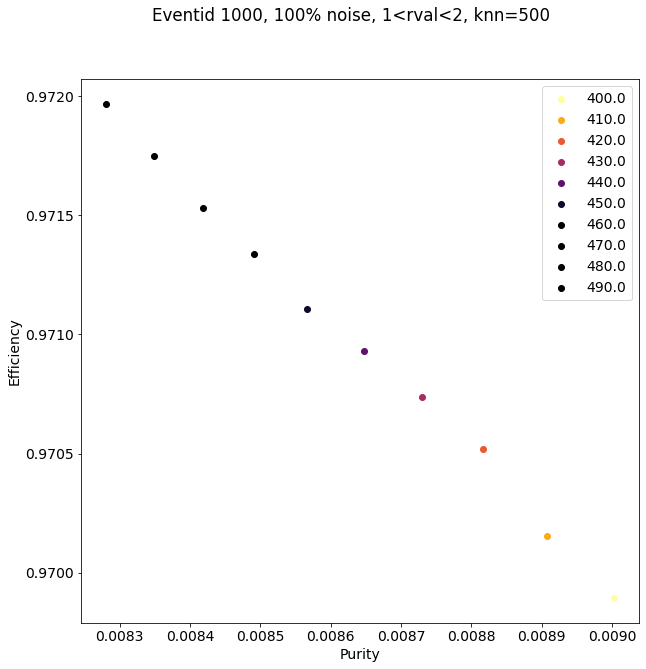

In [24]:
fig6, ax = plt.subplots(figsize=(10,10))
fig6.suptitle(f'Eventid {evtid}, 100% noise, 1<rval<2, knn=500')
n = len(p_kval)-1
colors = cm.inferno_r(np.linspace(0,n))
for i,val in enumerate(step):
    ax.scatter(p_kval[i],e_kval[i], color = colors[i], label = f'{val:.1f}')
ax.set_xlabel('Purity')
ax.set_ylabel('Efficiency')
ax.legend()